In [27]:
# load kpt from file 
import json 
path = "/workspace/code/logs/triangulated/2025-10-10/07-24-16/run_3/joints_3d/COMBINED/frame_0030_3dpose.json"

with open(path, 'r') as f:
    data = json.load(f)
    

In [28]:
import numpy as np

joints_3d = np.array(data['joints_3d']) 
joints_3d

array([[ 7.11156321e+00,  4.77664995e+00,  8.26514359e+01],
       [ 7.65628862e+00,  3.58244658e+00,  7.81021881e+01],
       [ 6.85006475e+00,  3.04036593e+00,  7.59566727e+01],
       [ 3.80589700e+00,  6.68370306e-01,  6.04224014e+01],
       [ 3.31511116e+00,  1.03124285e+00,  5.38053818e+01],
       [ 1.56090498e+00,  2.49777389e+00,  5.74223442e+01],
       [-3.95873427e-01,  2.69828200e+00,  5.13386917e+01],
       [ 1.78935921e+00,  1.14556684e+01,  1.02157539e+02],
       [-3.97113633e+00,  1.14002380e+01,  7.56215134e+01],
       [ 2.75121307e+01,  9.84459915e+01,  5.65315247e+02],
       [ 5.73658884e-01,  5.17605133e+01,  2.32528015e+02],
       [-8.20380688e+00,  1.12320442e+01,  7.58450241e+01],
       [-8.92269897e+00,  1.06479893e+01,  6.41608734e+01],
       [ 1.32774033e+02, -4.60320129e+02, -1.59310999e+03],
       [-1.03610817e+02,  3.15598358e+02,  1.07309656e+03],
       [ 1.65949688e+01, -4.53252678e+01, -1.12151428e+02],
       [ 2.59221058e+01, -6.11878166e+01

In [29]:
import numpy as np

def remove_outliers(points, method="iqr", threshold=1.5):
    """
    从3D点集中去除偏离值（outliers）

    Args:
        points (np.ndarray): (N, 3) 的点坐标
        method (str): 使用方法，可选 ['iqr', 'zscore', 'mahalanobis']
        threshold (float): 阈值，默认 1.5（IQR法），或3.0（Z-score）

    Returns:
        inliers (np.ndarray): 保留的正常点
        outliers (np.ndarray): 被剔除的异常点
        mask (np.ndarray): 布尔掩码 (True=保留, False=剔除)
    """
    if points.ndim != 2 or points.shape[1] != 3:
        raise ValueError("输入必须是形状为 (N,3) 的 ndarray")

    # 1️⃣ IQR法（最常用，鲁棒且无需标准化）
    if method == "iqr":
        Q1 = np.percentile(points, 25, axis=0)
        Q3 = np.percentile(points, 75, axis=0)
        IQR = Q3 - Q1
        lower = Q1 - threshold * IQR
        upper = Q3 + threshold * IQR
        mask = np.all((points >= lower) & (points <= upper), axis=1)

    # 2️⃣ Z-score法（基于标准差）
    elif method == "zscore":
        mean = np.mean(points, axis=0)
        std = np.std(points, axis=0)
        z = np.abs((points - mean) / std)
        mask = np.all(z < threshold, axis=1)

    # 3️⃣ Mahalanobis距离法（对多维分布更鲁棒）
    elif method == "mahalanobis":
        mean = np.mean(points, axis=0)
        cov = np.cov(points, rowvar=False)
        inv_cov = np.linalg.inv(cov)
        diff = points - mean
        d2 = np.einsum("ij,jk,ik->i", diff, inv_cov, diff)
        mask = d2 < (threshold ** 2)

    else:
        raise ValueError(f"未知方法: {method}")

    inliers = points[mask]
    outliers = points[~mask]
    return inliers, outliers, mask


In [30]:
# COCO-17 骨架（左/右臂、腿、躯干、头部）
COCO_SKELETON = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 4),
    (5, 7),
    (7, 9),
    (6, 8),
    (8, 10),
    (5, 6),
    (5, 11),
    (6, 12),
    (11, 12),
    (11, 13),
    (13, 15),
    (12, 14),
    (14, 16),
]

(11, 3) (6, 3) (17,)


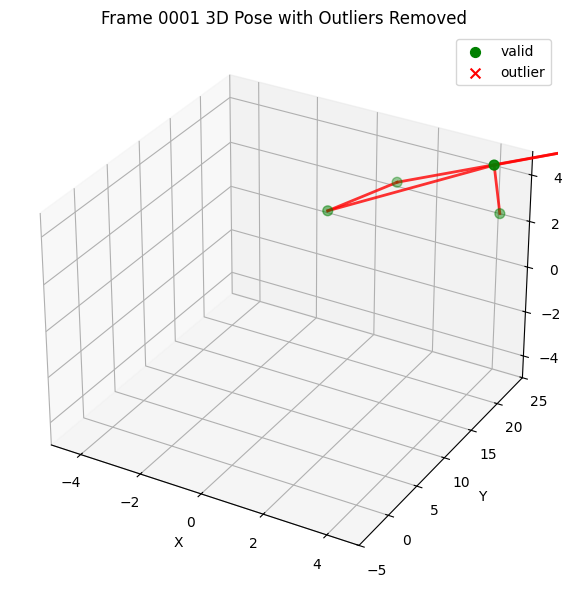

In [31]:
from matplotlib import pyplot as plt

inliers, outliers, valid_mask = remove_outliers(joints_3d, method="iqr", threshold=1.5)
print(inliers.shape, outliers.shape, valid_mask.shape)

points = np.asarray(joints_3d)
assert points.shape[1] == 3, "points 必须为 (N,3)"
N = points.shape[0]

# 若未提供mask，默认全部有效
if valid_mask is None:
    valid_mask = np.ones(N, dtype=bool)
valid_mask = np.asarray(valid_mask)

# 拆分坐标
x, z, y = points[:, 0], -points[:, 1], points[:, 2]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

# 绘制点（颜色区分有效/无效）
ax.scatter(x[valid_mask], y[valid_mask], z[valid_mask], c='g', s=50, label='valid')
ax.scatter(x[~valid_mask], y[~valid_mask], z[~valid_mask], c='r', s=50, marker='x', label='outlier')

# 绘制骨架连线（仅当两个端点都有效）
for i, j in COCO_SKELETON:
    if i < N and j < N and valid_mask[i] and valid_mask[j]:
        ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], c="r", lw=2, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim([-5, 5])
ax.set_ylim([-5, 25])
ax.set_zlim([-5, 5])

title = "Frame 0001 3D Pose with Outliers Removed"
ax.set_title(title)
ax.legend()
plt.tight_layout()
plt.show()

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- 1) 生成一批 3D 点（OpenCV 相机坐标系） ----------------
# OpenCV 相机系: x→右, y→下, z→前

# ---------------- 2) 相机内参与投影 ----------------
fx, fy = 800.0, 800.0
cx, cy = 320.0, 240.0
K = np.array([[fx, 0,  cx],
              [0,  fy, cy],
              [0,   0,  1]], dtype=float)

# 正确的 3x4 投影矩阵 P = K [I | 0]
P = K @ np.hstack([np.eye(3), np.zeros((3, 1))])  # (3,4)

# 齐次坐标
X_h = np.hstack([inliers, np.ones((N, 1))])  # (N,4)
proj = (P @ X_h.T).T                      # (N,3)
uv = proj[:, :2] / proj[:, 2:3]           # (N,2) 像素坐标 (u,v)

# ---------------- 3) Matplotlib 坐标变换（OpenCV -> Matplotlib） ----------------
# Matplotlib 3D 常用右手系: x→右, y→前, z→上
# 映射矩阵（与前文一致）
M_cv2plt = np.array([
    [1, 0, 0],   # x -> x
    [0, 0, 1],   # z -> y
    [0, -1, 0],  # -y -> z
], dtype=float)

X_plt = (M_cv2plt @ X_cv.T).T  # (N,3)

# ---------------- 4) 可视化 ----------------
W, H = 640, 480

fig = plt.figure(figsize=(15, 5))

# A) 图像平面上的 2D 投影（与 OpenCV 对齐：origin='upper'）
ax0 = fig.add_subplot(131)
ax0.imshow(np.full((H, W, 3), 240, dtype=np.uint8), origin='upper')
ax0.scatter(uv[:, 0], uv[:, 1], s=16, c='r', edgecolors='k')
ax0.set_title("A: 2D 投影 (origin='upper' 与 cv2 对齐)")
ax0.set_xlim(0, W); ax0.set_ylim(H, 0)   # 明确坐标方向与图像一致
ax0.set_xlabel("u (px)"); ax0.set_ylabel("v (px)")

# B) 直接用 OpenCV 相机坐标的点（未做坐标系映射）
ax1 = fig.add_subplot(132, projection='3d')
ax1.scatter(X_cv[:, 0], X_cv[:, 1], X_cv[:, 2], c='orange', s=16, depthshade=True)
ax1.set_title("B: 原始 OpenCV 相机系\n(x→右, y→下, z→前)")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z")
ax1.view_init(elev=20, azim=45)
ax1.set_box_aspect([1, 1, 1])

# C) 转为 Matplotlib 风格坐标后的点
ax2 = fig.add_subplot(133, projection='3d')
ax2.scatter(X_plt[:, 0], X_plt[:, 1], X_plt[:, 2], c='dodgerblue', s=16, depthshade=True)
ax2.set_title("C: 映射到 Matplotlib 风格\n(x→右, y→前, z→上)")
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("z")
ax2.view_init(elev=20, azim=45)
ax2.set_box_aspect([1, 1, 1])

plt.tight_layout()
plt.show()


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 11 and the array at index 1 has size 17